In [3]:
from ceruleanml import data
from icevision.parsers import COCOMaskParser
from icevision.data import SingleSplitSplitter
from fastai.data.block import DataBlock
from fastai.vision.data import ImageBlock, MaskBlock
from fastai.vision.augment import aug_transforms
from fastai.vision.learner import unet_learner
from fastai.data.transforms import RandomSplitter, Normalize
from fastai.metrics import Dice
from ceruleanml.coco_load_fastai import record_collection_to_record_ids, get_image_path, record_to_mask
from torchvision.models import resnet18, resnet34, resnet50
from fastai.callback.fp16 import MixedPrecision
from fastai.callback.tensorboard import TensorBoardCallback
from datetime import datetime
from pathlib import Path
import os
import torch

### Parsing COCO Dataset with Icevision

In [4]:
data_path = "/root/"
mount_path = "/root/data"

In [5]:
class_map = {v: k for k, v in data.class_mapping_coco_inv.items()}
class_ints = list(range(1, len(list(class_map.keys())[:-1]) + 1))
parser = COCOMaskParser(annotations_filepath=f"{mount_path}/tile-cerulean-v2-partial-with-context/instances_Tiled Cerulean Dataset V2.json", img_dir=f"{mount_path}/tile-cerulean-v2-partial-with-context/tiled_images")
train_records, valid_records = parser.parse(autofix=False)

  0%|          | 0/3883 [00:00<?, ?it/s]

### Importing functions for returning an image sample and a semantic segmentation label for each sample

In [6]:
record_ids = record_collection_to_record_ids(train_records)

### Constructing a FastAI DataBlock that uses parsed COCO Dataset from icevision parser and applies transformations

In [7]:
def get_image_by_record_id(record_id):
    return get_image_path(train_records, record_id)
def get_mask_by_record_id(record_id):
    return record_to_mask(train_records, record_id)

In [8]:
mean = [60.73,       190.3,      4.3598]
std = [16.099,      17.846,       9.603]

In [9]:
batch_transfms = [aug_transforms(),  Normalize.from_stats(mean,std)]

In [10]:
#size = 64  # Progressive resizing could happen here
augs = aug_transforms(flip_vert=True, max_warp=0.1) #, size=size)
coco_seg_dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=class_ints)),
    get_x=get_image_by_record_id,
    splitter=RandomSplitter(),
    get_y=get_mask_by_record_id,
    batch_tfms=[Normalize.from_stats(mean,std)],
    n_inp=1,
)

dls = coco_seg_dblock.dataloaders(source=record_ids, batch_size=1)

/root/miniconda3/envs/fastai2/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
coco_seg_dblock.summary(record_ids)

### Fastai2 Trainer

In [14]:
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d_%b_%Y_%H_%M_%S")
experiment_dir =  Path(f'{mount_path}/experiments/cv2/'+timestampStr+'_fastai_unet/')
experiment_dir.mkdir(exist_ok=True)

In [20]:
arch = 18
archs = {18: resnet18, 34: resnet34, 50: resnet50}

epoch,train_loss,valid_loss,dice,time
0,0.109063,0.136317,0.000000,04:50


epoch,train_loss,valid_loss,dice,time
0,0.142590,0.126728,0.003073,05:05


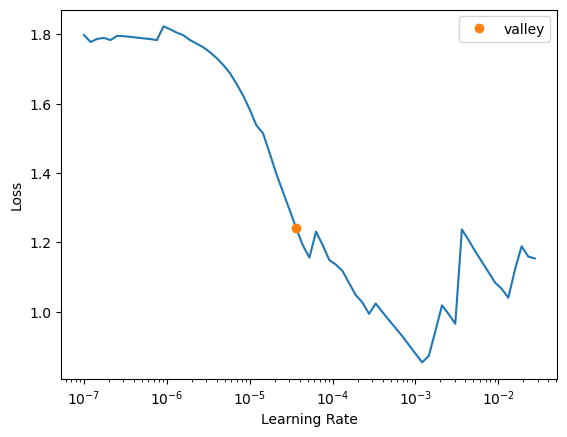

In [21]:
learner = unet_learner(dls, archs[arch], metrics=[Dice()], model_dir=experiment_dir, n_out = 7, cbs=[MixedPrecision]) # cbs=[MixedPrecision]

lr = learner.lr_find()

cbs = [TensorBoardCallback(projector=False, trace_model=False)]

learner.fine_tune(1, 2e-4, cbs=cbs)#, cbs=SaveModelCallback(monitor='dice'))w

In [22]:
validation = learner.validate()

In [23]:
size=512
savename = f'test_1batch_{arch}_{size}_{round(validation[1],3)}.pt'

In [31]:
from ceruleanml.inference import save_fastai_model_state_dict_and_tracing, load_tracing_model, test_tracing_model_one_batch, logits_to_classes

In [35]:
def save_fastai_model_state_dict_and_tracing(learner, dls, savename, experiment_dir):
    sd = learner.model.state_dict()
    torch.save(sd, f'{experiment_dir}/state_dict_{savename}') # saves state_dict for loading with fastai
    x,_ = dls.one_batch()
    learner.model.cuda()
    learner.model.eval()
    torch.jit.save(torch.jit.trace(learner.model, x),f'{experiment_dir}/tracing_{savename}')
    print(f'{experiment_dir}/tracing_{savename}')
    print(f'{experiment_dir}/state_dict_{savename}')
    return f'{experiment_dir}/state_dict_{savename}', f'{experiment_dir}/tracing_{savename}'


In [36]:
state_dict_pth, tracing_model_pth = save_fastai_model_state_dict_and_tracing(learner, dls, savename, experiment_dir)

/root/data/experiments/cv2/20_May_2022_21_28_57_fastai_unet/tracing_test_1batch_18_512_0.003.pt
/root/data/experiments/cv2/20_May_2022_21_28_57_fastai_unet/state_dict_test_1batch_18_512_0.003.pt


In [37]:
import torch
experiment_dir = '/root/data/experiments/cv2/20_May_2022_19_29_39_fastai_unet'
savename = "tracing_test_1batch_18_512_0.125.pt"
tracing_model = load_tracing_model(experiment_dir, savename)
out_batch_logits = test_tracing_model_one_batch(dls, tracing_model)

In [38]:
conf, classes = logits_to_classes(out_batch_logits)

In [40]:
classes.shape

torch.Size([1, 512, 512])

In [41]:
conf.shape

torch.Size([1, 512, 512])

In [ ]:
learn.show_results(max_n=4, figsize=(20,20), vmin=0, vmax=3)

Default path for tensorboard logs is `./runs/`

In [8]:
f'{mount_path}/experiments/cv2/'

'/root/data/experiments/cv2/'

In [10]:
!ls '/root/data/experiments/cv2/20_May_2022_19_29_39_fastai_unet'

state_dict_test_1batch_18_512_0.125.pt	tracing_test_1batch_18_512_0.125.pt


In [4]:
!ls './runs/'

ls: cannot access 'f{mount_path}/experiments/cv2/': No such file or directory


Copy logs to appropriate exeriments folder in the mounted GCS volume.

In [ ]:
!cp -R './runs/' {modelpath}'/tensorboard/'

Now, run the following from anywhere with gcs authenticated:

In [ ]:
!tensorboard --logdir="./runs"


# Model Inference and Result Evaluation

In [9]:
import torch

In [10]:
learner = torch.load("/root/data/experiments/cv2/10_May_2022_18_02_59_fastai_unet/18_64_0.493.pkl")

In [11]:
learner.predict??

Signature: learner.predict(item, rm_type_tfms=None, with_input=False)
Docstring: Prediction on `item`, fully decoded, loss function decoded and probabilities
Source:   
    def predict(self, item, rm_type_tfms=None, with_input=False):
        dl = self.dls.test_dl([item], rm_type_tfms=rm_type_tfms, num_workers=0)
        inp,preds,_,dec_preds = self.get_preds(dl=dl, with_input=True, with_decoded=True)
        i = getattr(self.dls, 'n_inp', -1)
        inp = (inp,) if i==1 else tuplify(inp)
        dec = self.dls.decode_batch(inp + tuplify(dec_preds))[0]
        dec_inp,dec_targ = map(detuplify, [dec[:i],dec[i:]])
        res = dec_targ,dec_preds[0],preds[0]
        if with_input: res = (dec_inp,) + res
        return res
File:      ~/miniconda3/envs/fastai2/lib/python3.9/site-packages/fastai/learner.py
Type:      method


In [ ]:
import skimage.io as skio
val_record_ids = record_collection_to_record_ids(valid_records)
pred_arrs = []
with learner.no_logging():
    for i in val_record_ids:
        p = get_image_path(valid_records,i)
        arr = skio.imread(p)
        pred_arr = learner.predict(arr)
        pred_arrs.append(pred_arr)

In [ ]:
# this results in vm dying, not just kernel crash
# coco_seg_dblock = DataBlock(
#     blocks=(ImageBlock, MaskBlock(codes=class_ints)),
#     get_x=get_image_by_record_id,
#     get_y=get_mask_by_record_id,
#     n_inp=1,
# )

# dls = coco_seg_dblock.dataloaders(source=record_ids, batch_size=5)


In [ ]:
result = learner.get_preds(dl=dls[0])

In [ ]:
learner.get_preds??

In [ ]:
len(pred_arrs)

In [ ]:
target_label,prediction_arr, activations = pred_arrs[0]

In [ ]:
skio.imshow(target_label.cpu().detach().numpy())

In [ ]:
skio.imshow(base_img.cpu().detach().numpy()[0])

In [ ]:
skio.imshow(base_img.cpu().detach().numpy()[1])

In [ ]:
skio.imshow(base_img.cpu().detach().numpy()[1])

In [ ]:
skio.imshow(base_img.cpu().detach().numpy())

In [ ]:
array([      60.73,       190.3,      4.3598]) # means
array([     16.099,      17.846,       9.603]) # stats